In [1]:
import torch
from torch import optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tt

from utils import CustomDataSet, load_data, print_config, DeviceDataLoader, supervised_samples, calc_mean_std, plotting, get_PATH, set_random_seed, CreateDataLoader
import config

from Classifier import Classifier

In [2]:
print_config()

RANDOM_SEED   :  11042004
DATA_DIR      :    ./data
USED_DATA     :    DOODLE
NUM_LABELLED  :        -1
DEVICE        :    cuda:0
GAN_BATCH_SIZE:       128


In [3]:
if config.NUM_LABELLED == -1:
	epochs = 5
	batch_size = 512
else:
	epochs = 20
	batch_size = 32
lr = 0.0002


In [4]:
set_random_seed(config.RANDOM_SEED)

Setting seeds ...... 



In [5]:
name = "CNN"

In [6]:
PATH = get_PATH(name)
PATH

'DOODLE/CNN/_full'

In [7]:
if config.USED_DATA == "CIFAR10":
	mean = [0.5]*3
	std = [0.5]*3
	train_tfm = tt.Compose([
		tt.RandomCrop(32, padding=4, padding_mode='edge'),
		tt.RandomHorizontalFlip(),
		tt.Normalize(mean, std, inplace=True)
	])

else:
# if config.USED_DATA == "MNIST" or config.USED_DATA == "DOODLE":
	mean = [0.5]
	std = [0.5]
	train_tfm = tt.Compose([
		tt.Resize(32),
		tt.Normalize(mean, std, inplace=True)
	])

test_tfm = tt.Compose([
	tt.Resize(32),
	tt.Normalize(mean, std)
])

In [8]:
train_ds, test_ds, classes = load_data(train_tfm, test_tfm)

In [9]:
classes

['0 - helicopter',
 '1 - car',
 '2 - book',
 '3 - windmill',
 '4 - cat',
 '5 - umbrella',
 '6 - octopus',
 '7 - bird',
 '8 - hat',
 '9 - birthday cake']

In [10]:
n_classes = len(classes)
channels = train_ds.x.shape[1]
n_classes, channels

(10, 1)

In [11]:
X_sup, y_sup = supervised_samples(train_ds.x, train_ds.y, config.NUM_LABELLED, n_classes)

In [12]:
sup_ds = CustomDataSet(X_sup, y_sup, train_tfm)

In [21]:
train_dl = CreateDataLoader(sup_ds, batch_size=batch_size, device=config.DEVICE)
test_dl = CreateDataLoader(test_ds, batch_size=batch_size, device=config.DEVICE)


In [14]:
model = Classifier(channels, n_classes).to(config.DEVICE, non_blocking=True)
model

Classifier(
  (conv): ConvModel(
    (initial): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (Conv): Sequential(
      (0): ConvBn(
        (Conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBn(
        (Conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): ConvBn(
        (Conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (Bn): BatchNorm2d(512, eps=1e-05

In [15]:
history = model.fit(epochs, lr, train_dl, opt_func=optim.Adam, sched=False, PATH=PATH+".pt", save=True)

Epoch [0]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.2639
Epoch [1]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.1934
Epoch [2]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.1432
Epoch [3]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.1202
Epoch [4]


  0%|          | 0/118 [00:00<?, ?it/s]

train_loss: 0.1155


In [22]:
model.evaluate(test_dl)

0.9455000162124634

In [17]:
import pickle

In [18]:
with open(PATH + ".pickle", 'wb') as f:
	pickle.dump(history, f)

In [19]:
with open(PATH + ".pickle", 'rb') as f:
	history = pickle.load(f)

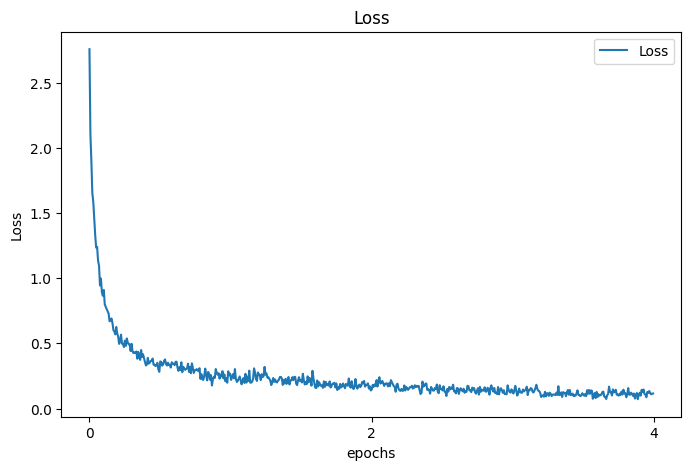

In [20]:
plotting(history)